##Dependencies

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
from collections import Counter
import seaborn as sns
from datetime import datetime
from scipy.sparse import coo_matrix, hstack, csr_matrix,vstack
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,r2_score,mean_absolute_error,mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from scipy.stats import chisquare
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn import datasets

##Loading Dataset

In [430]:
data_df = pd.read_csv("/content/drive/MyDrive/dataset_link/CS1.zip")

In [350]:
data_df.head()

,incident_state,active,reassignment_count,reopen_count,sys_mod_count,made_sla,opened_by,contact_type,location,category,subcategory,u_symptom,impact,urgency,priority,knowledge,u_priority_confirmation,notify,vendor,SLA_days_to_complete,SLA_range,opened_day,opened_month,opened_day_name
0,New,True,0,0,0,True,Opened by 8,Phone,Location 143,Category 55,Subcategory 170,Symptom 72,2 - Medium,2 - Medium,3 - Moderate,True,False,Do Not Notify,?,21,3.0,29,2,Monday
1,Resolved,True,0,0,2,True,Opened by 8,Phone,Location 143,Category 55,Subcategory 170,Symptom 72,2 - Medium,2 - Medium,3 - Moderate,True,False,Do Not Notify,?,21,3.0,29,2,Monday
2,Resolved,True,0,0,3,True,Opened by 8,Phone,Location 143,Category 55,Subcategory 170,Symptom 72,2 - Medium,2 - Medium,3 - Moderate,True,False,Do Not Notify,?,21,3.0,29,2,Monday
3,Closed,False,0,0,4,True,Opened by 8,Phone,Location 143,Category 55,Subcategory 170,Symptom 72,2 - Medium,2 - Medium,3 - Moderate,True,False,Do Not Notify,?,21,3.0,29,2,Monday
4,New,True,0,0,0,True,Opened by 397,Phone,Location 165,Category 40,Subcategory 215,Symptom 471,2 - Medium,2 - Medium,3 - Moderate,True,False,Do Not Notify,?,31,3.0,29,2,Monday


We will print the corelation between numericals and categorical set of attributes for better understanding of feature inportance


In [351]:
data_df.dtypes

incident_state              object
active                        bool
reassignment_count           int64
reopen_count                 int64
sys_mod_count                int64
made_sla                      bool
opened_by                   object
contact_type                object
location                    object
category                    object
subcategory                 object
u_symptom                   object
impact                      object
urgency                     object
priority                    object
knowledge                     bool
u_priority_confirmation       bool
notify                      object
vendor                      object
SLA_days_to_complete         int64
SLA_range                  float64
opened_day                   int64
opened_month                 int64
opened_day_name             object
dtype: object

##Dataset feature engg

We will convert day and month int64 dtype to object as they represent days and all days are nominal

creating list of numerical,categorical and boolean attributes 

In [431]:
num_attrib=['SLA_days_to_complete','reassignment_count','reopen_count','sys_mod_count','opened_day','opened_month']

cat_attrib=['SLA_days_to_complete','incident_state', 'opened_by', 'contact_type', 'location','category',
            'subcategory','u_symptom', 'impact','urgency', 'priority', 'notify', 'vendor',
            'opened_day_name']
            
bool_columns = ['active','made_sla','knowledge','u_priority_confirmation']

###Numerical Attributes

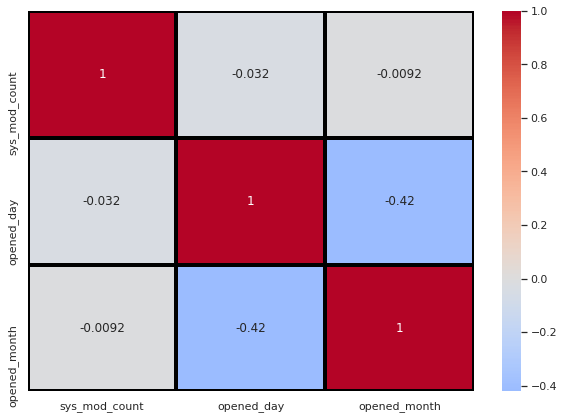

In [302]:
#coorilation between numerical features
plt.figure(figsize=(10,7))
sns.heatmap(data_df[num_attrib].corr(), annot = True, center= 0, cmap= 'coolwarm', linewidths=3, linecolor='black')
plt.show()

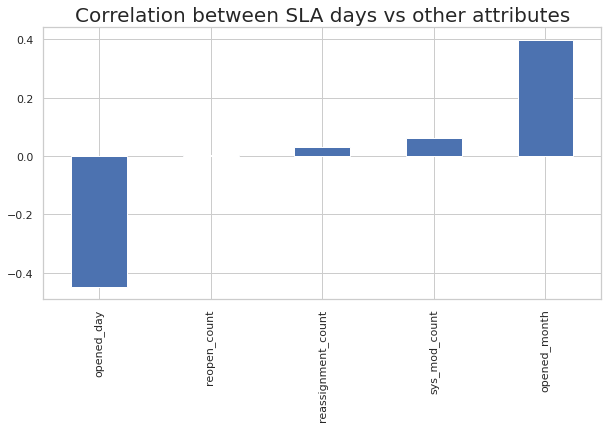

opened_day             -0.448342
reopen_count            0.001857
reassignment_count      0.030779
sys_mod_count           0.060217
opened_month            0.399229
SLA_days_to_complete    1.000000
Name: SLA_days_to_complete, dtype: float64

In [316]:
#bar plot of numerical features

plt.figure(figsize=(10,5))
temp_df=data_df[num_attrib].corr()
temp=temp_df.iloc[0].sort_values()
temp[:-1].plot(kind='bar')
plt.title('Correlation between SLA days vs other attributes',size=20)
plt.show()
temp

We can see that the reopen count and reassignment_count is very less related so we will drop this feature 

In [432]:
num_attrib=['sys_mod_count','opened_day','opened_month']

In [433]:
#standadizing the numerical attributes
minmax_scalar = MinMaxScaler()
data_df[num_attrib] = minmax_scalar.fit_transform(data_df[num_attrib])

#df of numerical attributes
std_num_feat_df=data_df[num_attrib] 

file_n = open('/content/drive/MyDrive/dataset_link/minmax_scale.pkl', 'wb')

# dump information to that file
pickle.dump(minmax_scalar, file_n)
file_n.close()

###Boolean

In [434]:
bool_columns = ['active','made_sla','knowledge','u_priority_confirmation']

In [435]:
#df of boolean attributes
#casting from boolean to integer
df_bool = pd.DataFrame(data_df, columns=bool_columns)

df_bool=df_bool.apply(lambda x: x.astype('uint8'))

In [436]:
df_bool.head()

,active,made_sla,knowledge,u_priority_confirmation
0,1,1,1,0
1,1,1,1,0
2,1,1,1,0
3,0,1,1,0
4,1,1,1,0


###Categorical

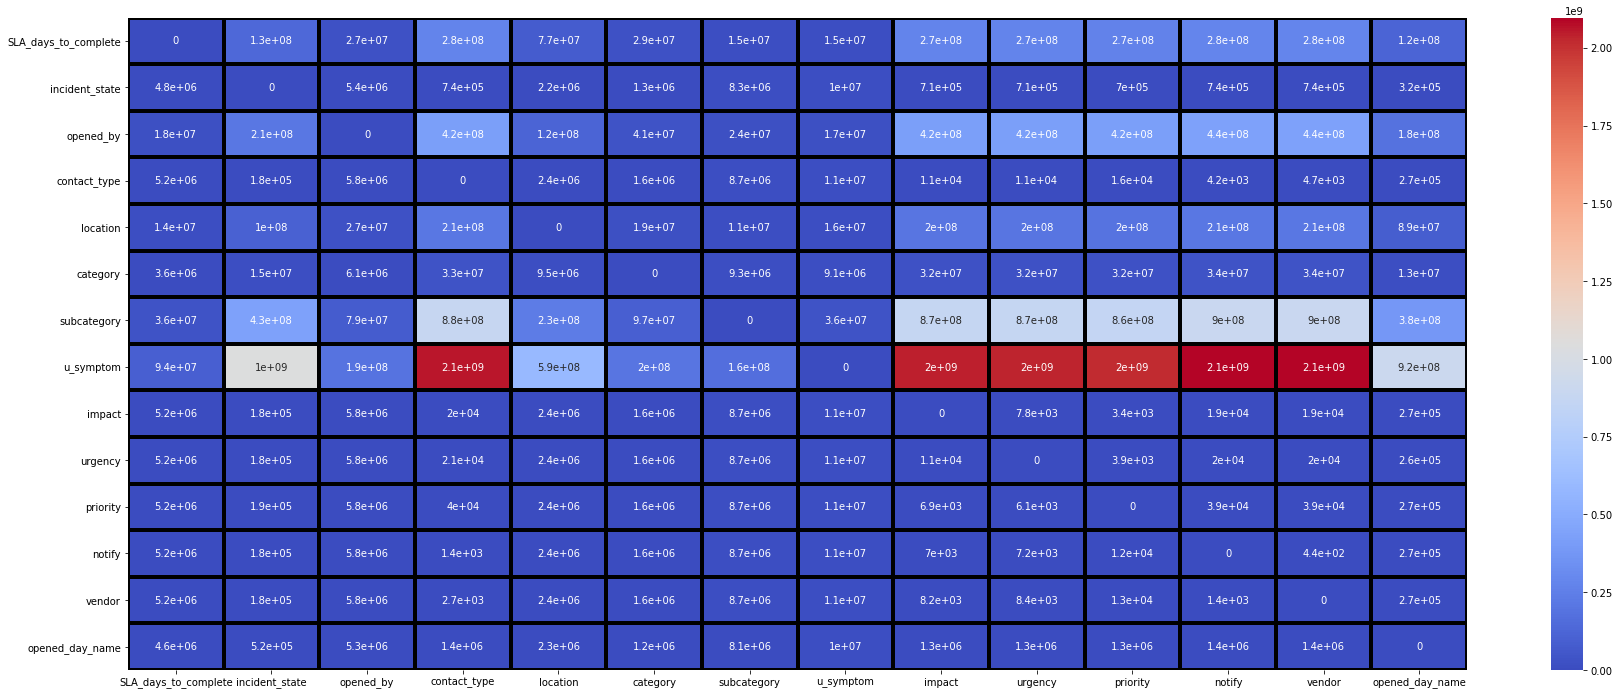

In [85]:
# For categorical attribues we are using chi square test

#https://stackoverflow.com/a/48035423/15411244

cat_df=data_df[cat_attrib].apply(lambda x : pd.factorize(x)[0])+1

cat_df=pd.DataFrame([chisquare(cat_df[x].values,f_exp=cat_df.values.T,axis=1)[0] for x in cat_df],columns=cat_attrib,index=cat_attrib)

plt.figure(figsize=(30,12))

sns.heatmap(cat_df.round(3), annot = True, cmap= 'coolwarm', linewidths=3, linecolor='black')

plt.show()

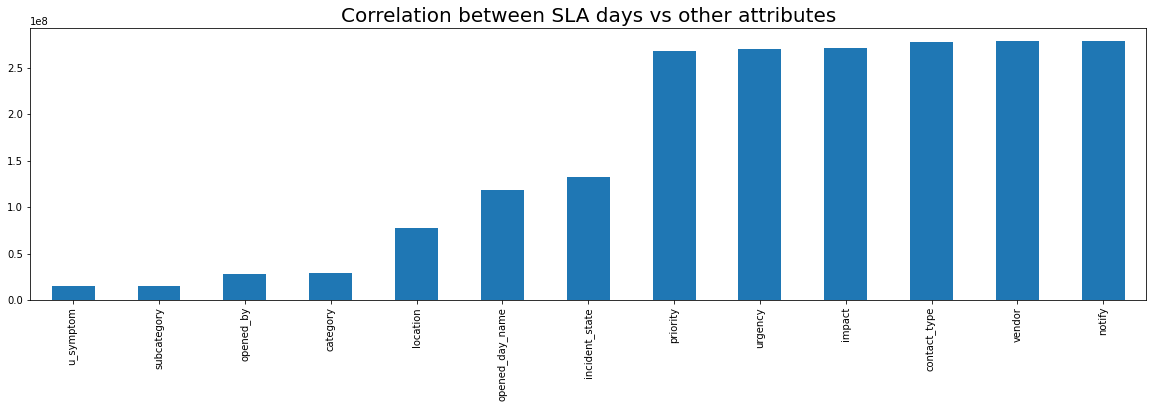

SLA_days_to_complete    0.000000e+00
u_symptom               1.509191e+07
subcategory             1.527425e+07
opened_by               2.743143e+07
category                2.850544e+07
location                7.698620e+07
opened_day_name         1.184449e+08
incident_state          1.324516e+08
priority                2.683308e+08
urgency                 2.708671e+08
impact                  2.709909e+08
contact_type            2.774193e+08
vendor                  2.788801e+08
notify                  2.789565e+08
Name: SLA_days_to_complete, dtype: float64

In [86]:
#bar plot of categorical attributes

plt.figure(figsize=(20,5))
temp=cat_df.iloc[0].sort_values()
temp[1:].plot(kind='bar')
plt.title('Correlation between SLA days vs other attributes',size=20)
plt.show()
temp

We can see that u_symptom, subcategory, opened_by, category are the lest corellated so we can drop these features

In [437]:
cat_attrib=['incident_state', 'contact_type', 'location','impact','urgency', 'priority', 'notify', 'vendor','opened_day_name']

In [438]:
#count of ? in the location attributes

data_df['location'].value_counts()['?']

76

we have '?' in our datset so we will convert it into 0

In [439]:
temp=data_df['location'].values
temp = [w.replace('?', 'Location 0') for w in temp]

data_df['location']=temp
data_df['location'].value_counts()['Location 0']

76

In [440]:
data_df['location'] = data_df['location'].str.extract("(\d*\.?\d+)", expand=True)

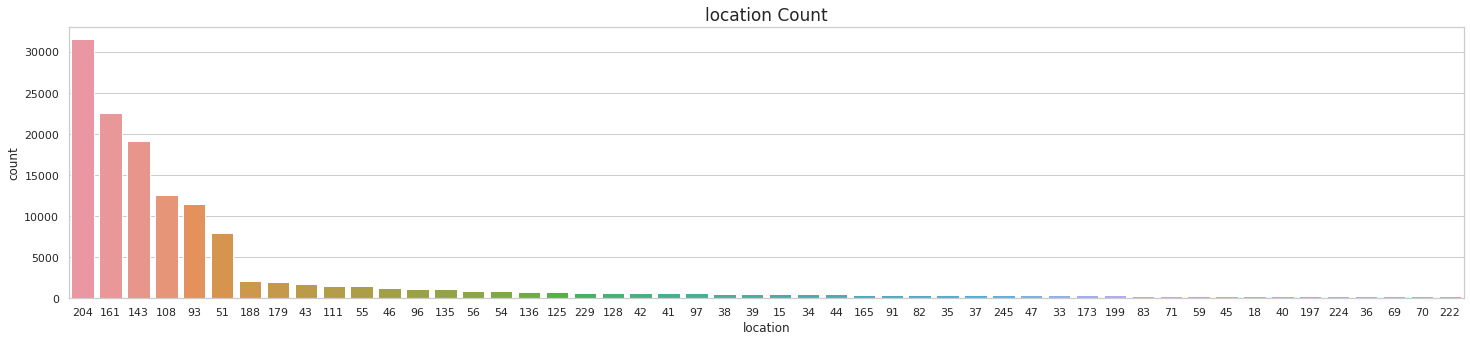

In [441]:
plt.figure(figsize=(25,5))
sns.set_theme(style="whitegrid")
ax = sns.countplot(x="location", data=data_df,order=data_df.location.value_counts().iloc[:50].index)
plt.title('location Count',size=17)
plt.xticks()
plt.show()

We can see that few have too much count other are very less so we will bucket it accrodnly

In [442]:
def binning_loc(arr):
    bin = [None]*arr.shape[0]
    for index,x in enumerate(arr):
        if x =='204':
            bin[index]='Location_A'
        elif x=='161':
            bin[index]='Location_B'
        elif x=='143':
            bin[index]='Location_C'
        elif x=='108':
            bin[index]='Location_D'
        elif x=='93':
            bin[index]='Location_E'
        elif x=='51':
            bin[index]='Location_F'
        else:
            bin[index]='Location_Unknown'
            
    return bin

In [443]:
temp_loc=binning_loc(data_df['location'].values)

data_df['location'] = temp_loc

In [444]:
data_df.location.value_counts()

Location_Unknown    35754
Location_A          31498
Location_B          22549
Location_C          19119
Location_D          12545
Location_E          11510
Location_F           7954
Name: location, dtype: int64

In [445]:
#count of ? in the vendor attributes

data_df['vendor'].value_counts()['?']

140685

In [446]:
def binning_vendor(arr):
    bin = [None]*arr.shape[0]
    for index,x in enumerate(arr):
        if x =='?':
            bin[index]='Vendor_Unknown'
        else:
            bin[index]= x
            pass
            
    return bin

In [447]:
temp_vendor=binning_vendor(data_df['vendor'].values)

data_df['vendor'] = temp_vendor

In [448]:
data_df['vendor'].value_counts()

Vendor_Unknown    140685
code 8s              167
Vendor 1              69
Vendor 3               6
Vendor 2               2
Name: vendor, dtype: int64

some attributes have same attributes name so we will encode them seperately

In [449]:
imapct_data=data_df['impact']
imapct_df=pd.get_dummies(imapct_data,prefix='impact',prefix_sep='')
imapct_df.head()

,impact1 - High,impact2 - Medium,impact3 - Low
0,0,1,0
1,0,1,0
2,0,1,0
3,0,1,0
4,0,1,0


In [450]:
urgency_data=data_df['urgency']
urgency_df=pd.get_dummies(urgency_data,prefix='urgency', prefix_sep='')
urgency_df.head()

,urgency1 - High,urgency2 - Medium,urgency3 - Low
0,0,1,0
1,0,1,0
2,0,1,0
3,0,1,0
4,0,1,0


In [451]:
data_df['priority'].value_counts()
priority_data=data_df['priority']
priority_df=pd.get_dummies(priority_data,prefix='priority', prefix_sep='')
priority_df.head()

,priority1 - Critical,priority2 - High,priority3 - Moderate,priority4 - Low
0,0,0,1,0
1,0,0,1,0
2,0,0,1,0
3,0,0,1,0
4,0,0,1,0


In [452]:
cat_attrib=['incident_state', 'contact_type', 'location', 'notify', 'vendor','opened_day_name']

In [453]:
#one hot encoding of categorical attributes

cat_data_df=pd.get_dummies(data_df[cat_attrib],prefix='', prefix_sep='')

cat_data_df.head()

,Active,Awaiting Evidence,Awaiting Problem,Awaiting User Info,Awaiting Vendor,Closed,New,Resolved,Direct opening,Email,IVR,Phone,Self service,Location_A,Location_B,Location_C,Location_D,Location_E,Location_F,Location_Unknown,Do Not Notify,Send Email,Vendor 1,Vendor 2,Vendor 3,Vendor_Unknown,code 8s,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0


In [454]:
#target column
target_col=data_df['SLA_days_to_complete']
target_col.shape

(140929,)

In [455]:
#concat all the datadfames
sparse_df=pd.concat([cat_data_df,std_num_feat_df,df_bool,imapct_df,priority_df,urgency_df], axis=1)
sparse_df.shape

(140929, 51)

In [468]:
sparse_df.head()

,Active,Awaiting Evidence,Awaiting Problem,Awaiting User Info,Awaiting Vendor,Closed,New,Resolved,Direct opening,Email,IVR,Phone,Self service,Location_A,Location_B,Location_C,Location_D,Location_E,Location_F,Location_Unknown,Do Not Notify,Send Email,Vendor 1,Vendor 2,Vendor 3,Vendor_Unknown,code 8s,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,sys_mod_count,opened_day,opened_month,active,made_sla,knowledge,u_priority_confirmation,impact1 - High,impact2 - Medium,impact3 - Low,priority1 - Critical,priority2 - High,priority3 - Moderate,priority4 - Low,urgency1 - High,urgency2 - Medium,urgency3 - Low
0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0.000000,0.933333,0.090909,1,1,1,0,0,1,0,0,0,1,0,0,1,0
1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0.017094,0.933333,0.090909,1,1,1,0,0,1,0,0,0,1,0,0,1,0
2,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0.025641,0.933333,0.090909,1,1,1,0,0,1,0,0,0,1,0,0,1,0
3,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0.034188,0.933333,0.090909,0,1,1,0,0,1,0,0,0,1,0,0,1,0
4,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0.000000,0.933333,0.090909,1,1,1,0,0,1,0,0,0,1,0,0,1,0


we can observe that opened_days are the least corellated to the SLA days to complete

In [480]:
sparse_df.columns = sparse_df.columns.str.replace(' ', '_')
sparse_df.columns = sparse_df.columns.str.replace('[-]', '')

In [481]:
sparse_df.head()

,Active,Awaiting_Evidence,Awaiting_Problem,Awaiting_User_Info,Awaiting_Vendor,Closed,New,Resolved,Direct_opening,Email,IVR,Phone,Self_service,Location_A,Location_B,Location_C,Location_D,Location_E,Location_F,Location_Unknown,Do_Not_Notify,Send_Email,Vendor_1,Vendor_2,Vendor_3,Vendor_Unknown,code_8s,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,sys_mod_count,opened_day,opened_month,active,made_sla,knowledge,u_priority_confirmation,impact1__High,impact2__Medium,impact3__Low,priority1__Critical,priority2__High,priority3__Moderate,priority4__Low,urgency1__High,urgency2__Medium,urgency3__Low
0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0.000000,0.933333,0.090909,1,1,1,0,0,1,0,0,0,1,0,0,1,0
1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0.017094,0.933333,0.090909,1,1,1,0,0,1,0,0,0,1,0,0,1,0
2,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0.025641,0.933333,0.090909,1,1,1,0,0,1,0,0,0,1,0,0,1,0
3,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0.034188,0.933333,0.090909,0,1,1,0,0,1,0,0,0,1,0,0,1,0
4,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0.000000,0.933333,0.090909,1,1,1,0,0,1,0,0,0,1,0,0,1,0


##Train test split

In [470]:
x_train, x_test, y_train, y_test = train_test_split(sparse_df,target_col, test_size=0.3, random_state=101)

In [471]:
print('x_train :',x_train.shape,'  y_train :',y_train.shape)
print('x_test  :',x_test.shape,'  y_test  :',y_test.shape)

x_train : (98650, 51)   y_train : (98650,)
x_test  : (42279, 51)   y_test  : (42279,)


In [473]:
x_test.head()

,Active,Awaiting_Evidence,Awaiting_Problem,Awaiting_User_Info,Awaiting_Vendor,Closed,New,Resolved,Direct_opening,Email,IVR,Phone,Self_service,Location_A,Location_B,Location_C,Location_D,Location_E,Location_F,Location_Unknown,Do_Not_Notify,Send_Email,Vendor_1,Vendor_2,Vendor_3,Vendor_Unknown,code_8s,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,sys_mod_count,opened_day,opened_month,active,made_sla,knowledge,u_priority_confirmation,impact1_-_High,impact2_-_Medium,impact3_-_Low,priority1_-_Critical,priority2_-_High,priority3_-_Moderate,priority4_-_Low,urgency1_-_High,urgency2_-_Medium,urgency3_-_Low
106132,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0.008547,0.133333,0.272727,1,1,0,0,0,1,0,0,0,1,0,0,1,0
113275,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0.017094,0.133333,0.727273,0,1,0,1,0,1,0,0,0,1,0,0,1,0
84914,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0.025641,0.566667,0.272727,1,1,0,0,0,1,0,0,0,1,0,0,1,0
58012,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0.017094,1.000000,0.181818,1,1,0,0,0,0,1,0,0,0,1,0,0,1
71664,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0.017094,0.100000,0.636364,1,1,0,0,0,1,0,0,0,1,0,0,1,0


##Utility function

In [459]:
#utility function

def binning(arr):
    bins = np.empty(arr.shape[0])
    for idx, x in enumerate(arr):
        if (x >= 0) & (x < 5):
            bins[idx] = 1
        elif (x >= 5) & (x < 15):
            bins[idx] = 2
        elif (x >= 15) & (x < 35):
            bins[idx] = 3
        elif (x >= 35) & (x < 60):
            bins[idx] = 4
        else:
            bins[idx] = 5
            
    return bins

def resultant(y_true, y_pred,model="Model"):

  val_1=mean_absolute_error(y_true, y_pred)
  val_2=r2_score(y_true, y_pred)
  val_3=mean_squared_error(y_true, y_pred)
  print("=="*50,'\n')
  print('Mean Absolute Error of {0} model is {1} \n'.format(model,val_1))
  print('R Square of {0} model is {1} \n'.format(model,val_2))
  
  y_true_bin=binning(y_true)
  y_pred_bin=binning(y_pred)

  conf = confusion_matrix(y_true_bin, y_pred_bin).round(3)
  plt.figure(figsize=(12,6))
  sns.heatmap(conf, annot = True, cmap= 'coolwarm', linewidths=3, linecolor='black')
  
  plt.title("Confusion Matrix",fontsize=20)
  plt.xlabel("Predicted Value",fontsize=16)
  plt.ylabel("True Value",fontsize=16)
  print("=="*50,'\n')
  print('After Binning of Actual and Predicted dates into timeframes \n')
  plt.show()
  print('\n',"=="*50,'\n')
  temp=pd.DataFrame({'actual':y_true_bin,'predicted':y_pred_bin})
  temp = temp.apply(pd.value_counts)
  temp.plot(kind='bar',figsize=(14,5),title ="Actual vs Predicted values in each timeframe bucket ",fontsize = 10)

##Base line Model (Random Values)

In [ ]:
#random y predct
from numpy.random import randint
# generate some integers
y_pred = randint(0, max(y_test),len(y_test))


Mean Absolute Error of Base model is 35.478440833510724 

R Square of Base model is -1.9142257362616353 


After Binning of Actual and Predicted dates into timeframes 



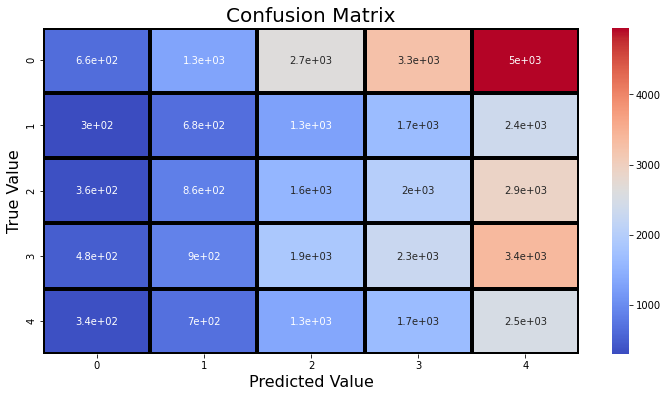

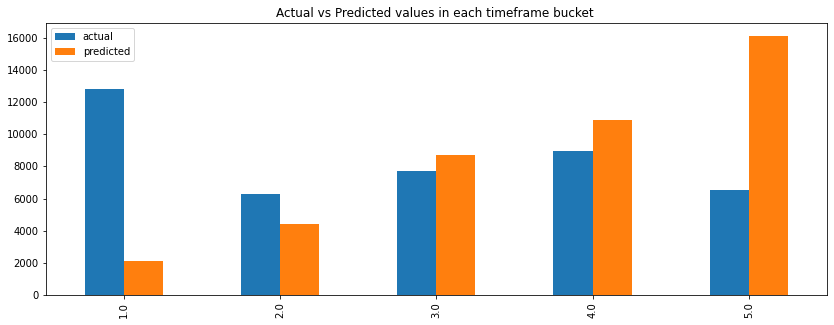

In [ ]:
resultant(y_test, y_pred,model="Base")

##Linear Regression

In [311]:
lr_reg = LinearRegression()

In [312]:
lr_reg_mod=lr_reg.fit(x_train,y_train)


Mean Absolute Error of Linear Regression model is 17.688685576763877 

R Square of Linear Regression model is 0.2606164872982403 


After Binning of Actual and Predicted dates into timeframes 



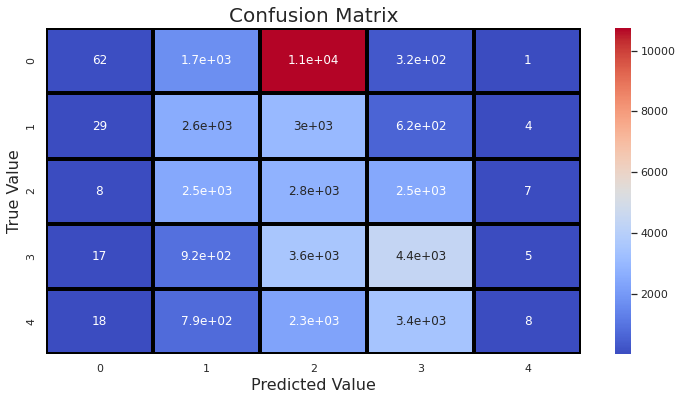

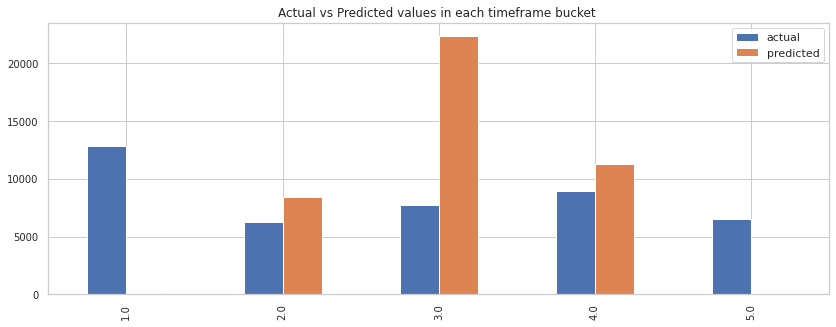

In [313]:
#cross validation
y_pred_test=lr_reg_mod.predict(x_test)
resultant(y_test, y_pred_test,model="Linear Regression")

##KNN Model

In [ ]:
model_knn = KNeighborsRegressor()

In [ ]:
metrics = ['euclidean','manhattan'] 
neighbors = np.arange(1, 16)
param_grid  = dict(metric=metrics, n_neighbors=neighbors)
param_grid

{'metric': ['euclidean', 'manhattan'],
 'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])}

In [ ]:
knn_clf = GridSearchCV(estimator=model_knn,param_grid=param_grid,cv=3,return_train_score=True,verbose=2,n_jobs=-1)

In [ ]:
knn_clf.fit(x_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 165.3min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 738.7min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=5, p=2,
                                           weights='uniform'),
             iid='deprecated', n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=2)

In [ ]:
knn_clf.best_estimator_

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='manhattan',
                    metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                    weights='uniform')

In [ ]:
knn_clf = KNeighborsRegressor(n_neighbors=2, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='manhattan', metric_params=None, n_jobs=-1)
knn_clf.fit(x_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='manhattan',
                    metric_params=None, n_jobs=-1, n_neighbors=2, p=2,
                    weights='uniform')


Mean Absolute Error of KNN Regressor model is 2.585456136616287 

R Square of KNN Regressor model is 0.8992582512399875 


After Binning of Actual and Predicted dates into timeframes 



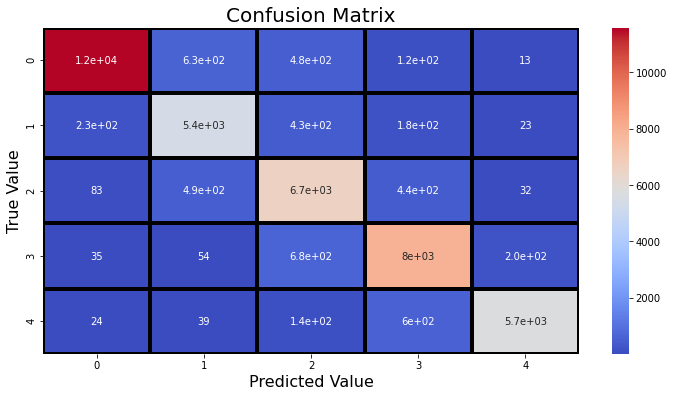

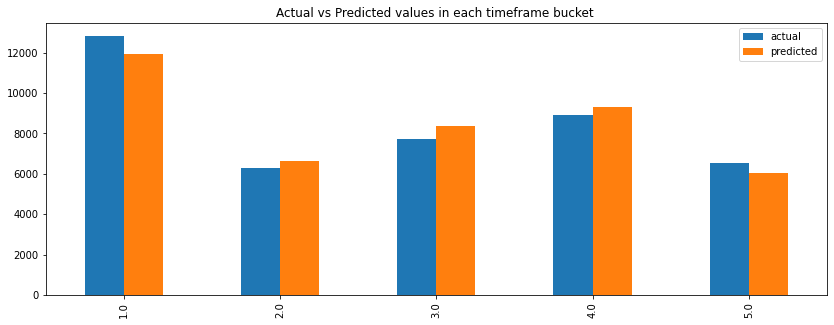

In [ ]:
#cross validation
y_pred_test=knn_clf.predict(x_test)
resultant(y_test, y_pred_test,model="KNN Regressor")

##SVR Model

In [ ]:
model_svr=SVR()

In [ ]:
kernel = ['poly', 'rbf'] 
degree=np.arange(3, 5)
gamma= [0.001, 0.0001]
C = [1, 10, 100]
param_grid  = dict(kernel=kernel,degree=degree, gamma=gamma, C=C)
param_grid

{'kernel': ['poly', 'rbf'],
 'degree': array([3, 4]),
 'gamma': [0.001, 0.0001],
 'C': [1, 10, 100]}

In [ ]:
svr_clf=GridSearchCV(estimator=model_svr,param_grid=param_grid,cv=3,return_train_score=True,verbose=2,n_jobs=-1)

In [ ]:
svr_clf.fit(x_train, y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


GridSearchCV(cv=3, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [1, 10, 100], 'degree': array([3, 4]),
                         'gamma': [0.001, 0.0001], 'kernel': ['poly', 'rbf']},
             return_train_score=True, verbose=2)

In [ ]:
svr_clf.best_estimator_

SVR(C=100, gamma=0.001)

In [ ]:
svr_reg=SVR(C=100, gamma=0.001)

In [ ]:
svr_reg.fit(x_train, y_train)

SVR(C=100, gamma=0.001)


Mean Absolute Error of XG Boost Regressor model is 11.169364299403522 

R Square of XG Boost Regressor model is 0.4608890459453532 


After Binning of Actual and Predicted dates into timeframes 



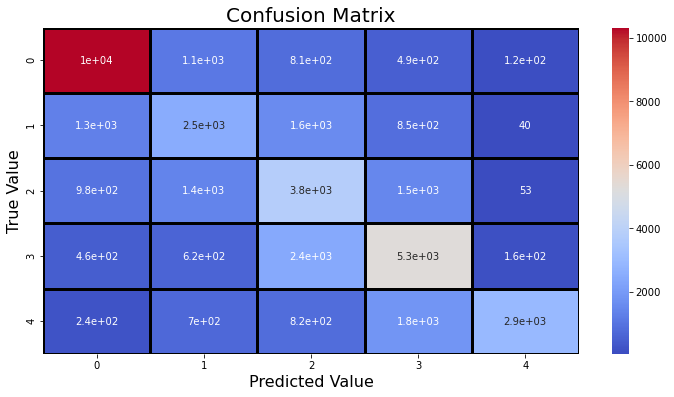

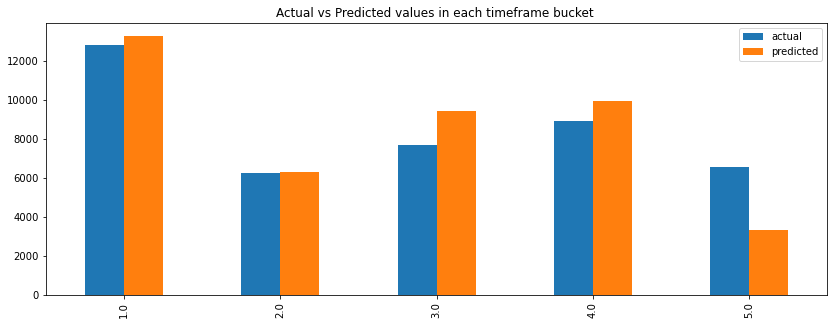

In [ ]:
#cross validation
y_pred_test=svr_reg.predict(x_test)
resultant(y_test, y_pred_test,model="SVR Regressor")

##XG Boost

In [ ]:
model_xgb = xgb.XGBRegressor()

In [ ]:
params = {
    'n_estimators': [100, 250, 500],
    'max_depth': [6, 9, 12],
    'subsample': [0.9, 1.0],
    'colsample_bytree': [0.9, 1.0],
}

In [ ]:
xgb_reg = GridSearchCV(model_xgb,params, n_jobs=-1,scoring="r2", cv=3, verbose=1)

In [ ]:
xgb_reg.fit(x_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_para

In [ ]:
xgb_reg.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=12,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.9,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
xgb_reg=xgb.XGBRegressor( colsample_bytree=0.9,
             learning_rate=0.300000012, max_depth=12,
             n_estimators=500, n_jobs=8,subsample=0.9)

In [ ]:
xgb_reg.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=12,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.9,
             tree_method='exact', validate_parameters=1, verbosity=None)


Mean Absolute Error of XG Boost Regressor model is 4.223746666010816 

R Square of XG Boost Regressor model is 0.913879048302068 


After Binning of Actual and Predicted dates into timeframes 



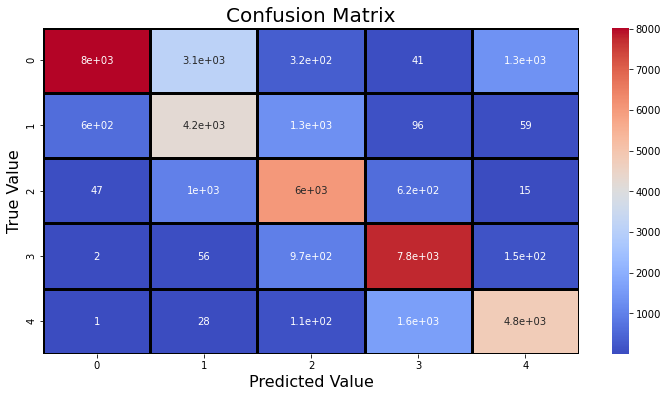

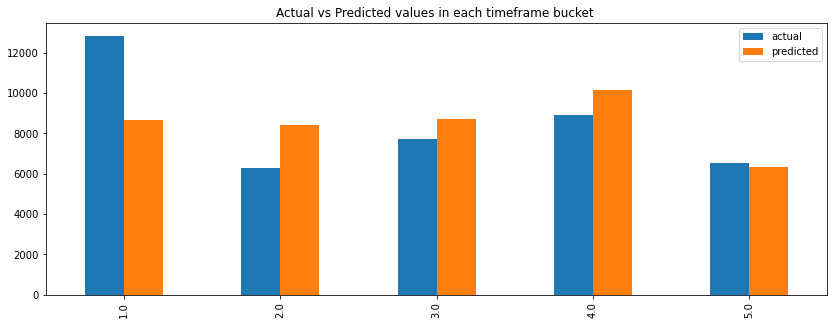

In [ ]:
#cross validation
y_pred_test=xgb_reg.predict(x_test)
resultant(y_test, y_pred_test,model="XG Boost Regressor")

##Random Forest Regressor

In [ ]:
model_rf = RandomForestRegressor()

In [ ]:
{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

In [ ]:
params = { 'max_depth': [10, 20, 30, 40, 50],
            "n_estimators" : [10,100,500],
            "max_features" : ["auto", "sqrt"],
            "min_samples_split" : [2,4,8]
            }

In [ ]:
rf_grid= GridSearchCV(model_rf,params, cv=3,scoring='r2',return_train_score=True,verbose=2,n_jobs=-1)

In [ ]:
rf_grid.fit(x_train, y_train)

Fitting 3 folds for each of 90 candidates, totalling 270 fits


/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30, 40, 50],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_split': [2, 4, 8],
                         'n_estimators': [10, 100, 500]},
             return_train_score=True, scoring='r2', verbose=2)

In [ ]:
rf_grid.best_estimator_

RandomForestRegressor(max_depth=50, n_estimators=500)

In [ ]:
model_rf = RandomForestRegressor(max_depth=50, n_estimators=500)

In [ ]:
model_rf.fit(x_train, y_train)

RandomForestRegressor(max_depth=50, n_estimators=500)


Mean Absolute Error of Random Forest Tegressor model is 4.900758583281133 

R Square of Random Forest Tegressor model is 0.8581043666359287 


After Binning of Actual and Predicted dates into timeframes 



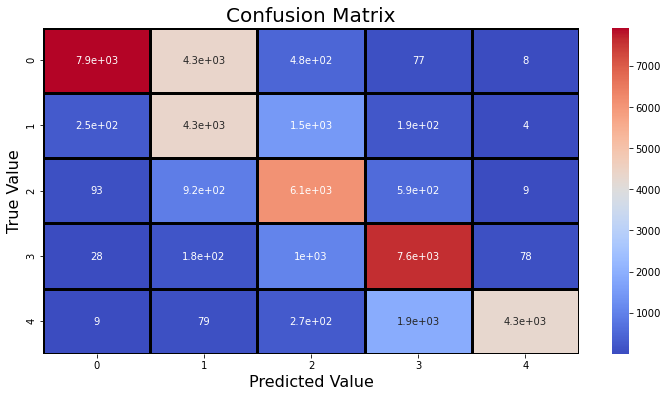

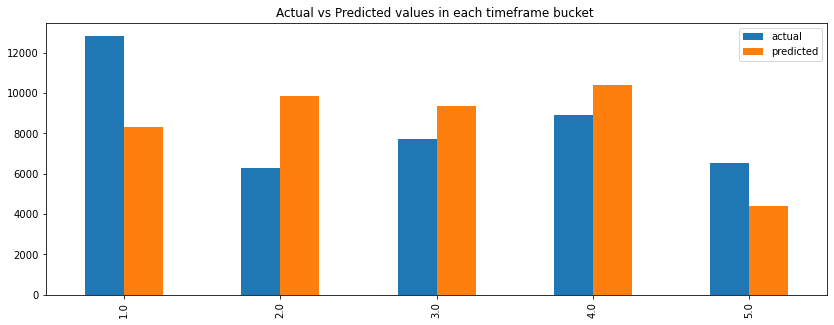

In [ ]:
#cross validation
y_pred_test=model_rf.predict(x_test)
resultant(y_test, y_pred_test,model="Random Forest Tegressor")

In [ ]:
# MLP Regressor
from sklearn.neural_network import MLPRegressor

In [ ]:
regr = MLPRegressor(hidden_layer_sizes=500,
                    learning_rate='adaptive',
                    early_stopping=True,
                    validation_fraction=0.3,
                    n_iter_no_change=25,
                    verbose=True).fit(x_train, y_train)

Iteration 1, loss = 249.38232273
Validation score: 0.497506
Iteration 2, loss = 146.11704747
Validation score: 0.568453
Iteration 3, loss = 125.77693602
Validation score: 0.616607
Iteration 4, loss = 111.88420344
Validation score: 0.645483
Iteration 5, loss = 101.47183246
Validation score: 0.673195
Iteration 6, loss = 91.41951536
Validation score: 0.698544
Iteration 7, loss = 82.67852402
Validation score: 0.720876
Iteration 8, loss = 74.84544311
Validation score: 0.738941
Iteration 9, loss = 68.65297687
Validation score: 0.755032
Iteration 10, loss = 63.30530552
Validation score: 0.768955
Iteration 11, loss = 58.82244797
Validation score: 0.781181
Iteration 12, loss = 54.89092448
Validation score: 0.789817
Iteration 13, loss = 51.31288689
Validation score: 0.800103
Iteration 14, loss = 48.35452764
Validation score: 0.807060
Iteration 15, loss = 45.79201293
Validation score: 0.812276
Iteration 16, loss = 43.49130603
Validation score: 0.818260
Iteration 17, loss = 41.21262016
Validation 

In [ ]:
#cross validation
y_pred_test=regr.predict(x_test)


Mean Absolute Error of MLP model is 3.869640059764268 

R Square of MLP model is 0.9200650429444666 


After Binning of Actual and Predicted dates into timeframes 



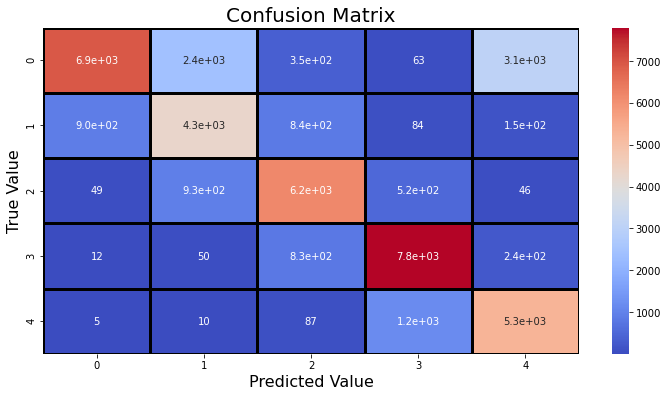

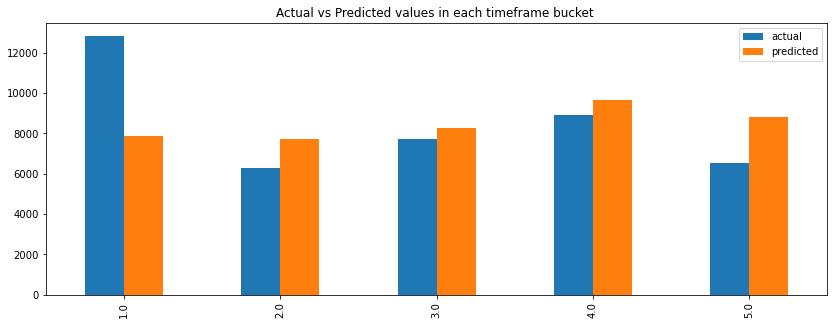

In [ ]:
resultant(y_test, y_pred_test,model="MLP")

##Custom stacking apporach

In [482]:
  import pickle

In [483]:
#concat dependent variable with independent variable
sparse_df_2=pd.concat([sparse_df,target_col], axis=1)

In [484]:
x_train_custom, x_test_custom = train_test_split(sparse_df_2, test_size=0.2, random_state=42)

In [460]:
!rm -rf /content/model

In [486]:
#base learners
base_models=[('base_m0',DecisionTreeRegressor()),
        ('base_m1',RandomForestRegressor()),
        ('base_m2',DecisionTreeRegressor()),
        ('base_m3',RandomForestRegressor()),
        ('base_m4',DecisionTreeRegressor()),
        ('base_m5',RandomForestRegressor()),
        ('base_m6',DecisionTreeRegressor())]

#meta learner
meta_model=RandomForestRegressor()

#sampling the k number of dataframes
def sampleDF(df, K): 
    temp=[]
    for i in range(K):
      x=df.sample(frac=0.8,replace=True)
      temp.append(x)
    return temp   

#custom stacking
def custom_stacking(df_train,df_test,base_models,meta_model,target_column):
  '''
  df_train- trainning dataset 
  df_test- test dataset
  base_models- base learners
  meta_model- meta gernealizer
  target_column- dependent variable
  '''
  target=target_column
  a,b=np.array_split(df_train,2) #creating 2 dataframes
  samp_df=sampleDF(a,len(base_models)) #creating sample dataframes form half training data
  base_pred=[] #base learnes predicted list
  base_reg=[] #base learner models
  for i,j in zip(samp_df,base_models): #fitting models and dataframes simultaneously
    reg=j[1].fit(i.drop(target,axis=1),i[target])
    file_b = open('/content/drive/MyDrive/dataset_link/'+j[0]+'.pkl', 'wb')
    # # dump information to that file
    pickle.dump(reg, file_b) 
    file_b.close()
    mod=pickle.load( open('/content/drive/MyDrive/dataset_link/'+j[0]+'.pkl', 'rb') )
    pred=mod.predict(b.drop(target,axis=1))
    base_pred.append(pred) 
    base_reg.append(reg)
  #creating dataframe from predicted list of array
  meta_df = pd.DataFrame(np.array(base_pred).T, columns=np.arange(len(base_models)))
  #fitting the predicted dataframe to meta lerner
  meta_reg=meta_model.fit(meta_df,b[target])

  file_m = open('/content/drive/MyDrive/dataset_link/meta_model.pkl', 'wb')

  # dump information to that file
  pickle.dump(meta_reg, file_m)
  file_m.close()
  meta_mod = open('/content/drive/MyDrive/dataset_link/meta_model.pkl','rb')
  my_model = pickle.load(meta_mod)

  test_pred=[] #predicted list of test data
  for i in base_reg:
    pred=i.predict(df_test.drop(target,axis=1))
    test_pred.append(pred)
  #creating dataframe of predicted test list of array
  meta_test_df = pd.DataFrame(np.array(test_pred).T, columns=np.arange(len(base_models)))
  #prediction using trained meta model
  test_meta_pred=my_model.predict(meta_test_df)
  #result 
  resultant(df_test[target], test_meta_pred,model="Custom Stacking Regressor")



Mean Absolute Error of Custom Stacking Regressor model is 9.919285996716178 

R Square of Custom Stacking Regressor model is 0.5874761258029317 


After Binning of Actual and Predicted dates into timeframes 



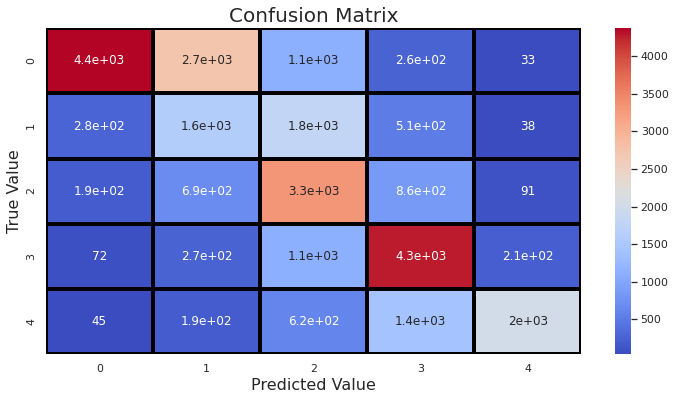

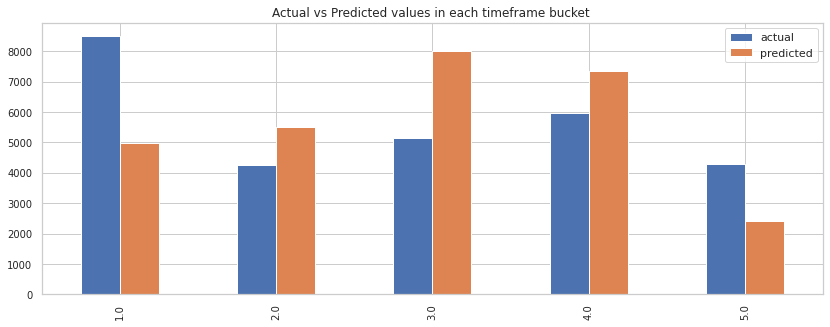

In [487]:
custom_stacking(x_train_custom, x_test_custom,base_models,meta_model,'SLA_days_to_complete')

In [485]:
x_test_custom.head()

,Active,Awaiting_Evidence,Awaiting_Problem,Awaiting_User_Info,Awaiting_Vendor,Closed,New,Resolved,Direct_opening,Email,IVR,Phone,Self_service,Location_A,Location_B,Location_C,Location_D,Location_E,Location_F,Location_Unknown,Do_Not_Notify,Send_Email,Vendor_1,Vendor_2,Vendor_3,Vendor_Unknown,code_8s,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,sys_mod_count,opened_day,opened_month,active,made_sla,knowledge,u_priority_confirmation,impact1__High,impact2__Medium,impact3__Low,priority1__Critical,priority2__High,priority3__Moderate,priority4__Low,urgency1__High,urgency2__Medium,urgency3__Low,SLA_days_to_complete
29239,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0.025641,0.433333,0.181818,1,1,0,0,0,1,0,0,0,1,0,0,1,0,3
128814,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0.008547,0.633333,0.363636,1,1,0,1,0,1,0,0,0,1,0,0,1,0,1
21928,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0.128205,0.066667,0.727273,0,0,1,1,0,1,0,0,0,1,0,0,1,0,30
96983,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0.059829,0.900000,0.272727,0,1,0,1,0,1,0,0,0,1,0,0,1,0,18
94778,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0.025641,0.866667,0.272727,0,1,0,1,0,1,0,0,0,1,0,0,1,0,27


In [488]:
x_test_custom.columns

Index(['Active', 'Awaiting_Evidence', 'Awaiting_Problem', 'Awaiting_User_Info',
       'Awaiting_Vendor', 'Closed', 'New', 'Resolved', 'Direct_opening',
       'Email', 'IVR', 'Phone', 'Self_service', 'Location_A', 'Location_B',
       'Location_C', 'Location_D', 'Location_E', 'Location_F',
       'Location_Unknown', 'Do_Not_Notify', 'Send_Email', 'Vendor_1',
       'Vendor_2', 'Vendor_3', 'Vendor_Unknown', 'code_8s', 'Friday', 'Monday',
       'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday',
       'sys_mod_count', 'opened_day', 'opened_month', 'active', 'made_sla',
       'knowledge', 'u_priority_confirmation', 'impact1__High',
       'impact2__Medium', 'impact3__Low', 'priority1__Critical',
       'priority2__High', 'priority3__Moderate', 'priority4__Low',
       'urgency1__High', 'urgency2__Medium', 'urgency3__Low',
       'SLA_days_to_complete'],
      dtype='object')

##Model Table

In [ ]:
from prettytable import PrettyTable

x = PrettyTable()

x.field_names = ["Model", "Mean Absolute Loss", "R Square score"]
x.add_row(["Base Model(Random)",35.478,-1.914])
x.add_row(["Liner Regression",12.668,0.539])
x.add_row(["KNN Regressor",2.585,0.899])
x.add_row(["SVR",11.169,0.460])
x.add_row(["XGBoost Regressor",4.223,0.913])
x.add_row(["Random Forest Regressor",4.900,0.858])
x.add_row(["MLP Regressor", 3.869,0.920])
x.add_row(["Custom Ensemble", 5.979,0.791])

print(x)

+-------------------------+--------------------+----------------+
|          Model          | Mean Absolute Loss | R Square score |
+-------------------------+--------------------+----------------+
|    Base Model(Random)   |       35.478       |     -1.914     |
|     Liner Regression    |       12.668       |     0.539      |
|      KNN Regressor      |       2.585        |     0.899      |
|           SVR           |       11.169       |      0.46      |
|    XGBoost Regressor    |       4.223        |     0.913      |
| Random Forest Regressor |        4.9         |     0.858      |
|      MLP Regressor      |       3.869        |      0.92      |
|     Custom Ensemble     |       5.979        |     0.791      |
+-------------------------+--------------------+----------------+


The best performing model is KNN Regressor

##Save the model to reuse it again

In [17]:
import pickle